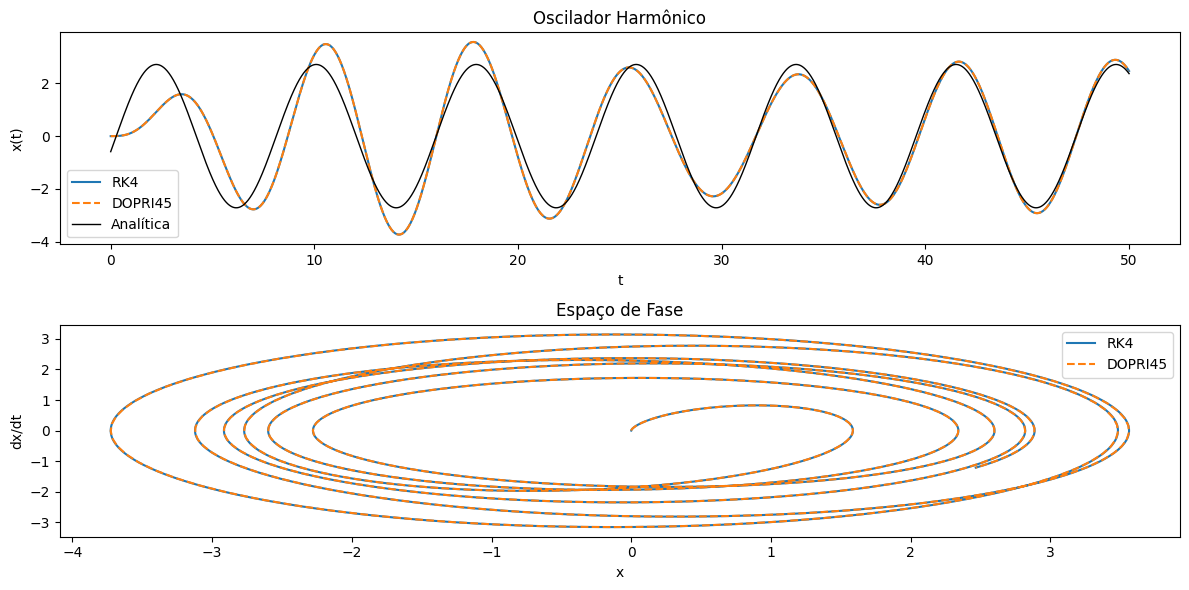

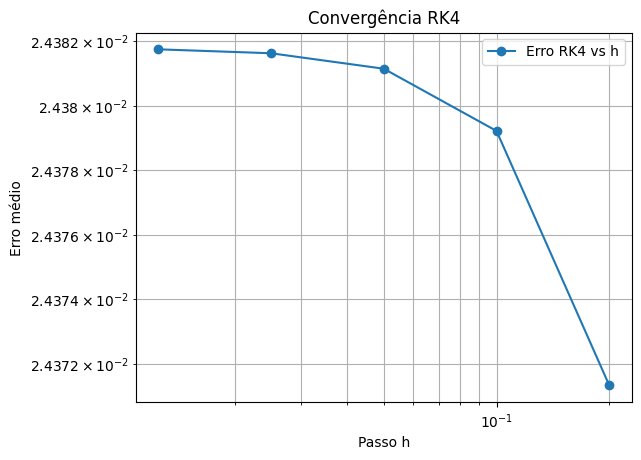

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Questão 1

# RK4 de passo fixo
def rk4(f, t_span, y0, h, args=()):
    t0, tf = t_span
    t_values = np.arange(t0, tf+h, h)
    y_values = np.zeros((len(t_values), len(y0)))
    y = np.array(y0, dtype=float)
    y_values[0] = y
    for i, t in enumerate(t_values[:-1]):
        k1 = np.array(f(t, y, *args))
        k2 = np.array(f(t + h/2, y + h*k1/2, *args))
        k3 = np.array(f(t + h/2, y + h*k2/2, *args))
        k4 = np.array(f(t + h, y + h*k3, *args))
        y = y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
        y_values[i+1] = y
    return t_values, y_values


# DOPRI45
def dopri45(f, t_span, y0, tol=1e-6, args=()):
    sol = solve_ivp(f, t_span, y0, method="RK45", args=args,
                    rtol=tol, atol=tol, dense_output=True)
    return sol.t, sol.y.T


# Simulação de um oscilador harmônico linear
def oscilador(t, Y, zeta, omega_n, gamma, Omega):
    x, v = Y
    dx = v
    dv = -2*zeta*omega_n*v - (omega_n**2)*x + gamma*np.sin(Omega*t)
    return [dx, dv]


# Solução analítica
def sol_analitica(t, zeta, omega_n, gamma, Omega):
    den = np.sqrt((omega_n**2 - Omega**2)**2 + (2*zeta*omega_n*Omega)**2)
    A = gamma / den
    phi = np.arctan2(2*zeta*omega_n*Omega, omega_n**2 - Omega**2)
    return A * np.sin(Omega*t - phi)



if __name__ == "__main__":
    # parâmetros
    zeta = 0.05
    omega_n = 1.0
    gamma = 1.0
    Omega = 0.8
    y0 = [0, 0]
    t_span = (0, 50)
    h = 0.01

    # RK4 fixo
    t_rk4, y_rk4 = rk4(oscilador, t_span, y0, h, args=(zeta, omega_n, gamma, Omega))

    # DOPRI45
    t_dopri, y_dopri = dopri45(oscilador, t_span, y0, tol=1e-8, args=(zeta, omega_n, gamma, Omega))

    # Solução analítica
    t = np.linspace(0, 50, 5000)
    x_analitica = sol_analitica(t, zeta, omega_n, gamma, Omega)

    # Gráficos
    plt.figure(figsize=(12,6))

    plt.subplot(2,1,1)
    plt.plot(t_rk4, y_rk4[:,0], label="RK4")
    plt.plot(t_dopri, y_dopri[:,0], '--', label="DOPRI45")
    plt.plot(t, x_analitica, 'k', lw=1, label="Analítica")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.legend()
    plt.title("Oscilador Harmônico")

    # Espaço de fase
    plt.subplot(2,1,2)
    plt.plot(y_rk4[:,0], y_rk4[:,1], label="RK4")
    plt.plot(y_dopri[:,0], y_dopri[:,1], '--', label="DOPRI45")
    plt.xlabel("x")
    plt.ylabel("dx/dt")
    plt.legend()
    plt.title("Espaço de Fase")

    plt.tight_layout()
    plt.show()

    # Análise de convergência
    hs = [0.2, 0.1, 0.05, 0.025, 0.0125]
    erros = []
    for h in hs:
        t_test, y_test = rk4(oscilador, (0, 20), y0, h, args=(zeta, omega_n, gamma, Omega))
        x_num = np.interp(t, t_test, y_test[:,0])
        x_ana = sol_analitica(t, zeta, omega_n, gamma, Omega)
        erro = np.linalg.norm(x_num - x_ana)/len(t)
        erros.append(erro)

    plt.figure()
    plt.loglog(hs, erros, 'o-', label="Erro RK4 vs h")
    plt.xlabel("Passo h")
    plt.ylabel("Erro médio")
    plt.title("Convergência RK4")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()


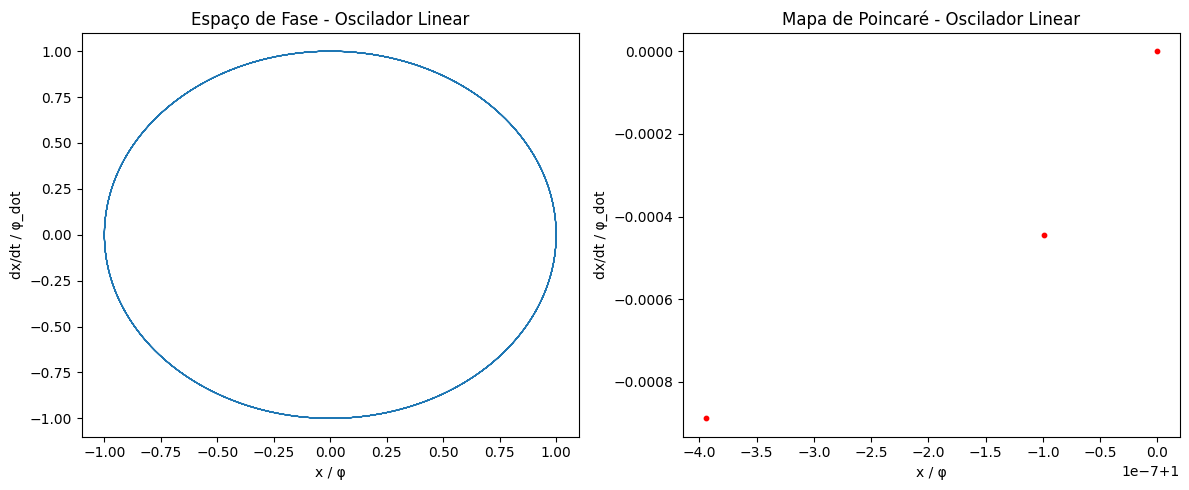

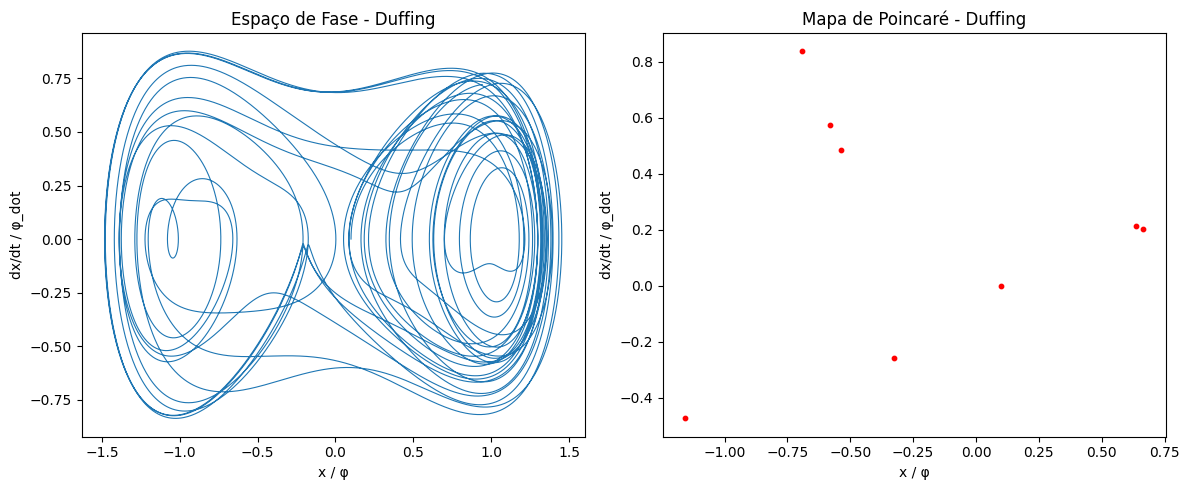

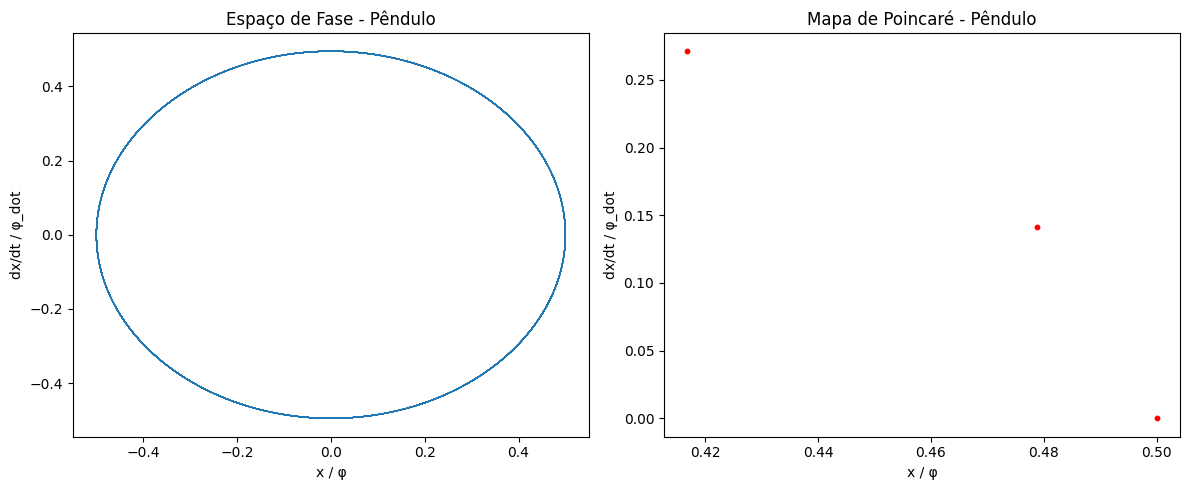

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Questão 2A

# RK4
def rk4_step(f, t, y, h, params):
    k1 = f(t, y, params)
    k2 = f(t + h/2, y + h/2 * k1, params)
    k3 = f(t + h/2, y + h/2 * k2, params)
    k4 = f(t + h, y + h * k3, params)
    return y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

def integrate(f, y0, t0, tf, h, params):
    t_vals = np.arange(t0, tf, h)
    y_vals = np.zeros((len(t_vals), len(y0)))
    y = np.array(y0, dtype=float)

    for i, t in enumerate(t_vals):
        y_vals[i] = y
        y = rk4_step(f, t, y, h, params)
    return t_vals, y_vals


# Oscilador linear não disspativo
def oscilador_linear(t, Y, params):
    x, v = Y
    omega = params[0]
    dxdt = v
    dvdt = -(omega**2)*x
    return np.array([dxdt, dvdt])


# Oscilador biestável tipo Duffing
def duffing(t, Y, params):
    x, v = Y
    delta, alpha, beta, gamma, omega = params
    dxdt = v
    dvdt = -2*delta*v - alpha*x - beta*x**3 + gamma*np.cos(omega*t)
    return np.array([dxdt, dvdt])


# Pêndulo simples
def pendulo(t, Y, params):
    phi, w = Y
    omega0 = params[0]
    dphi = w
    dw = -(omega0**2)*np.sin(phi)
    return np.array([dphi, dw])


# Gráficos
def plot_results(t, Y, system_name, poincare_T):
    plt.figure(figsize=(12,5))

    # Espaço de fase
    plt.subplot(1,2,1)
    plt.plot(Y[:,0], Y[:,1], lw=0.8)
    plt.xlabel("x / φ")
    plt.ylabel("dx/dt / φ_dot")
    plt.title(f"Espaço de Fase - {system_name}")

    # Mapa de Poincaré
    plt.subplot(1,2,2)
    poincare_points = []
    for i, ti in enumerate(t):
        if abs((ti % poincare_T)) < 1e-3:
            poincare_points.append(Y[i])
    poincare_points = np.array(poincare_points)
    if len(poincare_points) > 0:
        plt.scatter(poincare_points[:,0], poincare_points[:,1], s=10, c='r')
    plt.xlabel("x / φ")
    plt.ylabel("dx/dt / φ_dot")
    plt.title(f"Mapa de Poincaré - {system_name}")

    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    h = 0.01
    t0, tf = 0, 200

    # Oscilador Linear
    params_linear = (1.0,)
    T_linear = 2*np.pi/params_linear[0]
    t, Y = integrate(oscilador_linear, [1.0, 0], t0, 50, h, params_linear)
    plot_results(t, Y, "Oscilador Linear", T_linear)

    # Duffing
    params_duffing = (0.1, -1, 1, 0.3, 1.2)
    T_duffing = 2*np.pi/params_duffing[-1]
    t, Y = integrate(duffing, [0.1, 0], t0, tf, h, params_duffing)
    plot_results(t, Y, "Duffing", T_duffing)

    # Pêndulo
    params_pendulo = (1.0,)
    T_pendulo = 2*np.pi/params_pendulo[0]
    t, Y = integrate(pendulo, [0.5, 0], t0, 100, h, params_pendulo)
    plot_results(t, Y, "Pêndulo", T_pendulo)


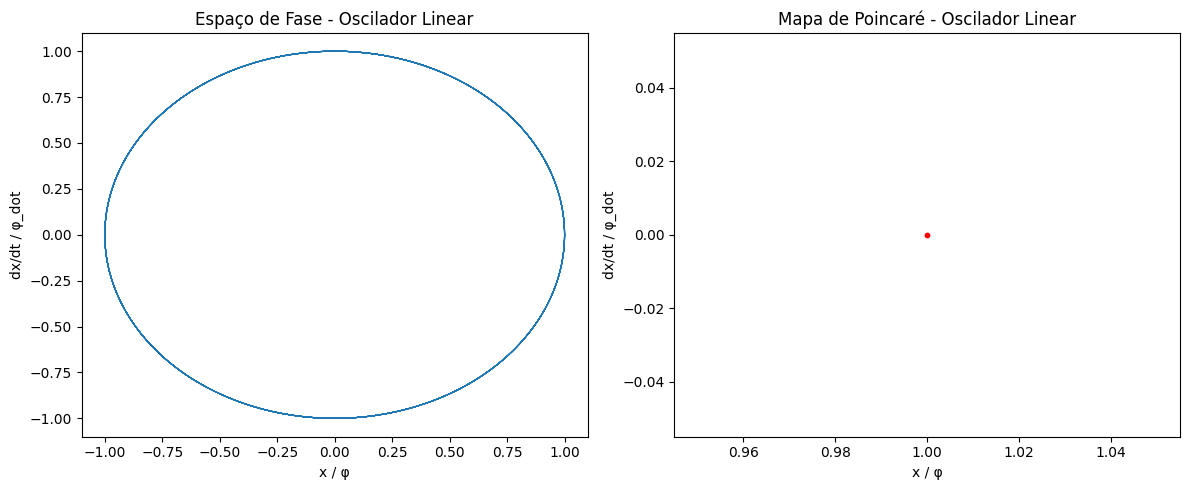

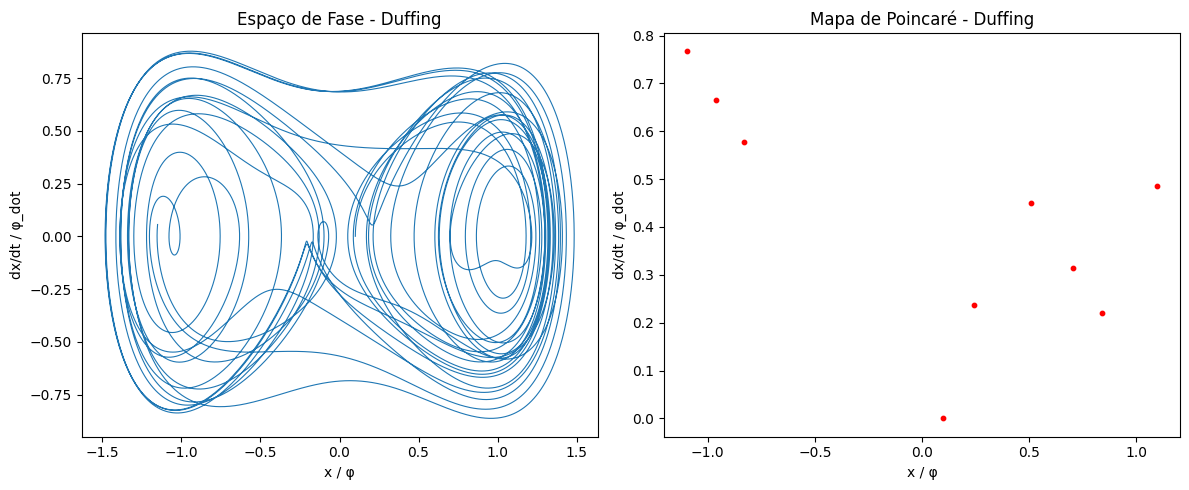

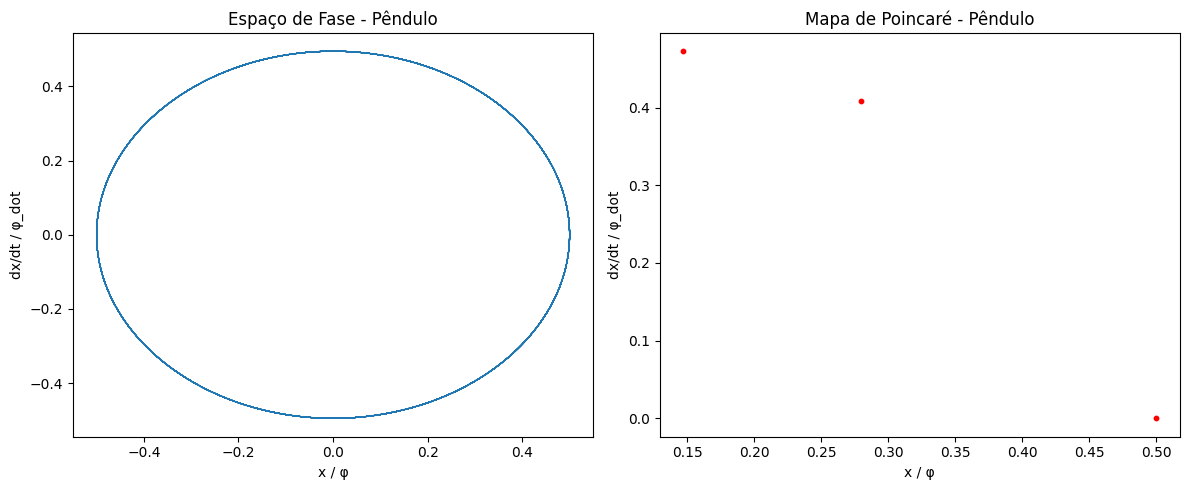

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Questão 2B

# Oscilador linear não dissipativo
def oscilador_linear(t, Y, omega):
    x, v = Y
    dxdt = v
    dvdt = -(omega**2)*x
    return [dxdt, dvdt]


# Oscilador biestável tipo Duffing
def duffing(t, Y, params):
    x, v = Y
    delta, alpha, beta, gamma, omega = params
    dxdt = v
    dvdt = -2*delta*v - alpha*x - beta*x**3 + gamma*np.cos(omega*t)
    return [dxdt, dvdt]


# Pêndulo simples
def pendulo(t, Y, omega0):
    phi, w = Y
    dphi = w
    dw = -(omega0**2)*np.sin(phi)
    return [dphi, dw]


# Gráficos
def plot_results(sol, system_name, poincare_T):
    t = sol.t
    Y = sol.y.T

    plt.figure(figsize=(12,5))

    # Espaço de fase
    plt.subplot(1,2,1)
    plt.plot(Y[:,0], Y[:,1], lw=0.8)
    plt.xlabel("x / φ")
    plt.ylabel("dx/dt / φ_dot")
    plt.title(f"Espaço de Fase - {system_name}")

    # Mapa de Poincaré
    plt.subplot(1,2,2)
    poincare_points = []
    for i, ti in enumerate(t):
        if abs((ti % poincare_T)) < (t[1]-t[0]):
            poincare_points.append(Y[i])
    poincare_points = np.array(poincare_points)
    if len(poincare_points) > 0:
        plt.scatter(poincare_points[:,0], poincare_points[:,1], s=10, c='r')
    plt.xlabel("x / φ")
    plt.ylabel("dx/dt / φ_dot")
    plt.title(f"Mapa de Poincaré - {system_name}")

    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    t0, tf = 0, 200

    # Oscilador Linear
    omega = 1.0
    T_linear = 2*np.pi/omega
    sol = solve_ivp(oscilador_linear, [t0, 50], [1.0, 0], args=(omega,),
                    method="RK45", max_step=0.01, dense_output=True)
    plot_results(sol, "Oscilador Linear", T_linear)

    # Duffing
    params_duffing = (0.1, -1, 1, 0.3, 1.2)
    T_duffing = 2*np.pi/params_duffing[-1]
    sol = solve_ivp(duffing, [t0, tf], [0.1, 0], args=(params_duffing,),
                    method="RK45", max_step=0.01, dense_output=True)
    plot_results(sol, "Duffing", T_duffing)

    # Pêndulo
    omega0 = 1.0
    T_pendulo = 2*np.pi/omega0
    sol = solve_ivp(pendulo, [t0, 100], [0.5, 0], args=(omega0,),
                    method="RK45", max_step=0.01, dense_output=True)
    plot_results(sol, "Pêndulo", T_pendulo)


In [ ]:
import numpy as np
from numpy.linalg import eig
from scipy.optimize import root

# Questão 3

# Jacobiano
def jacobiano(f, x, eps=1e-7, *args):
    x = np.asarray(x, float)
    n = x.size
    J = np.zeros((n, n))
    fx = np.asarray(f(0.0, x, *args), float)
    for j in range(n):
        dx = np.zeros(n); dx[j] = eps
        f2 = np.asarray(f(0.0, x+dx, *args), float)
        J[:, j] = (f2 - fx) / eps
    return J

# Autovalores
def classify_eigs(lmb):
    if np.all(np.real(lmb) < 0):
        return "assintoticamente estável"
    if np.any(np.real(lmb) > 0):
        return "instável"
    if np.allclose(np.real(lmb), 0, atol=1e-10):
        return "neutro/indeterminado"
    return "indeterminado"

# Pontos de equilíbrio
def equilibrio(f, guesses, args=()):
    eqs = []
    for g in guesses:
        sol = root(lambda y: np.asarray(f(0.0, y, *args), float), g, method="hybr")
        if sol.success:
            y = sol.x
            if not any(np.linalg.norm(y - e) < 1e-6 for e in eqs):
                eqs.append(y)
    return eqs

# Sistemas
def duffing(t, y, zeta, alpha, beta):
    x, v = y
    return np.array([v, -2*zeta*v - alpha*x - beta*x**3])

def pendulum(t, y, wn):
    phi, w = y
    return np.array([w, - wn**2 * np.sin(phi)])

def lorenz(t, y, sigma, rho, beta):
    x, y2, z = y
    return np.array([sigma*(y2 - x), rho*x - y2 - x*z, x*y2 - beta*z])

def gdl(t, y, z1, z2, a1, b1, rho, Om1, a2, b2, Om2):
    x1, v1, x2, v2 = y
    dx1 = v1
    dv1 = -2*z1*v1 + 2*z2*(v2 - v1) - (1+a1)*x1 - b1*x1**3 + rho*Om1**2*(x2 - x1)
    dx2 = v2
    dv2 = (-2*z2*(v2 - v1) - a2*x2 - b2*x2**3 - rho*Om2**2*(x2 - x1)) / rho
    return np.array([dx1, dv1, dx2, dv2])

# Análise do equilíbrio
def analyze_system(name, f, guesses, args=()):
    print(f"\n {name} ")
    eqs = equilibrio(f, guesses, args=args)
    if not eqs:
        print("Sem equilíbrio.")
        return
    for k, e in enumerate(eqs, 1):
        J = jacobiano(f, e, 1e-7, *args)
        lmb, _ = eig(J)
        print(f"Eq.{k}: {e}")
        print(f"Autovalores: {lmb}")
        print(f"Classificação: {classify_eigs(lmb)}\n")


if __name__ == "__main__":
    # (a) Duffing
    zeta, alpha, beta = 0.1, -1.0, 1.0
    guesses = [(-1.2,0.0), (0.0,0.0), (1.2,0.0)]
    analyze_system("Duffing (zeta=0.1, alpha=-1, beta=1)",
                   duffing, guesses, args=(zeta, alpha, beta))

    # (b) Pêndulo simples sem dissipação
    wn = 1.0
    guesses = [(0.0,0.0), (np.pi,0.0), (-np.pi,0.0), (2*np.pi,0.0)]
    analyze_system("Pêndulo (sem dissipação, wn=1)",
                   pendulum, guesses, args=(wn,))

    # (c) Lorenz
    sigma, rho, beta = 10.0, 28.0, 8.0/3.0
    guesses = [(0,0,0), (8,8,25), (-8,-8,25)]
    analyze_system("Lorenz (sigma=10, rho=28, beta=8/3)",
                   lorenz, guesses, args=(sigma, rho, beta))

    # (d) 2GDL multiestável
    pars = dict(z1=0.06, z2=0.04, a1=0.2, b1=1.0, rho=1.0, Om1=1.0,
                a2=0.2, b2=1.2, Om2=0.9)
    guesses = [(-1,0,-1,0), (0,0,0,0), (1,0,1,0), (1,0,-1,0), (-1,0,1,0)]
    analyze_system("2GDL multiestável",
                   gdl, guesses, args=tuple(pars.values()))



 Duffing (zeta=0.1, alpha=-1, beta=1) 
Eq.1: [-1.  0.]
Autovalores: [-0.1+1.41067349j -0.1-1.41067349j]
Classificação: assintoticamente estável

Eq.2: [0. 0.]
Autovalores: [ 0.90498756 -1.10498756]
Classificação: instável

Eq.3: [1. 0.]
Autovalores: [-0.1+1.4106737j -0.1-1.4106737j]
Classificação: assintoticamente estável


 Pêndulo (sem dissipação, wn=1) 
Eq.1: [0. 0.]
Autovalores: [0.+1.j 0.-1.j]
Classificação: neutro/indeterminado

Eq.2: [3.14159265 0.        ]
Autovalores: [ 1. -1.]
Classificação: instável

Eq.3: [-3.14159265  0.        ]
Autovalores: [ 1. -1.]
Classificação: instável

Eq.4: [6.28318531 0.        ]
Autovalores: [0.+1.j 0.-1.j]
Classificação: neutro/indeterminado


 Lorenz (sigma=10, rho=28, beta=8/3) 
Eq.1: [0. 0. 0.]
Autovalores: [-22.82772345  11.82772345  -2.66666667]
Classificação: instável

Eq.2: [ 8.48528137  8.48528137 27.        ]
Autovalores: [-13.85457784 +0.j           0.09395561+10.19450523j
   0.09395561-10.19450523j]
Classificação: instável

Eq.3: [-

Duffing
Equilíbrios encontrados: [array([-1.,  0.]), array([1., 0.]), array([0., 0.])]
Equilíbrios estáveis: [[-1.0, 0.0], [1.0, 0.0]]


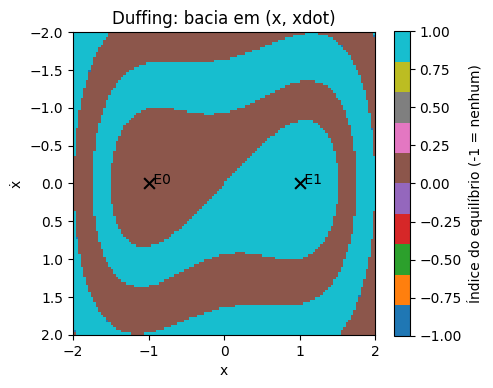

Pendulo
Equilíbrios encontrados: [array([0., 0.]), array([3.14159265, 0.        ]), array([-3.14159265,  0.        ]), array([6.28318531, 0.        ])]
Equilíbrios estáveis: [[0.0, 0.0], [6.283185307179586, 0.0]]


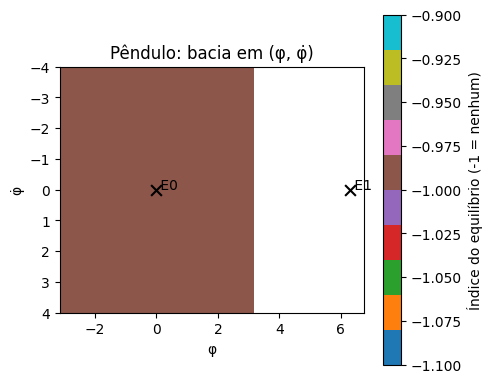

2GDL multiestavel
Equilíbrios encontrados: [array([0., 0., 0., 0.])]
Equilíbrios estáveis: 1


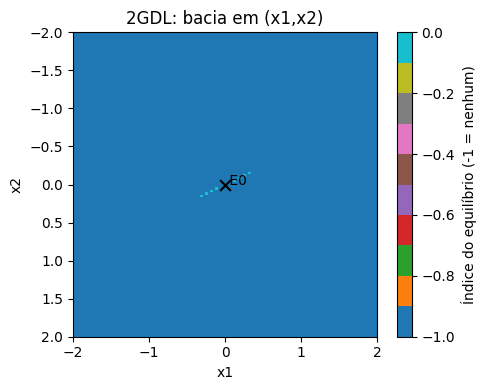

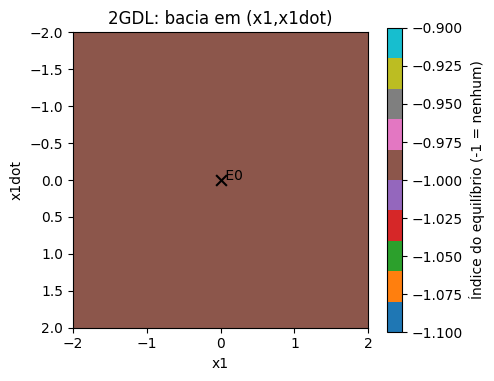

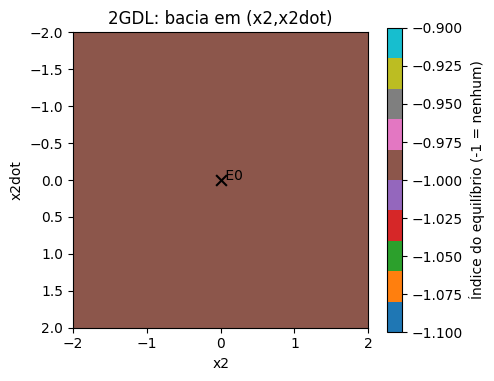

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
from numpy.linalg import eigvals

# Questão 4

# Equilíbrios
def equilibrios(rhs, dim, guesses, args=(), tol=1e-8):
    eqs = []
    for g in guesses:
        sol = root(lambda y: rhs(0.0, y, *args), g, method='hybr', tol=1e-10)
        if sol.success:
            y = np.array(sol.x, dtype=float)
            unique = True
            for e in eqs:
                if np.linalg.norm(y - e) < 1e-6:
                    unique = False; break
            if unique:
                eqs.append(y)
    return eqs

# Jacobiano
def jacob(rhs, x, args=(), eps=1e-7):
    x = np.asarray(x, float)
    n = x.size
    J = np.zeros((n,n))
    f0 = np.asarray(rhs(0.0, x, *args), float)
    for j in range(n):
        dx = np.zeros(n); dx[j] = eps
        f1 = np.asarray(rhs(0.0, x+dx, *args), float)
        J[:, j] = (f1 - f0)/eps
    return J

# Convergência
def classify_equilibrio(rhs, eqs, args=()):
    stable_eqs = []
    for e in eqs:
        J = jacob(rhs, e, args=args)
        ev = eigvals(J)
        if np.all(np.real(ev) < 0):
            stable_eqs.append((e, ev))
    return stable_eqs


def classify(rhs, y0, tmax, args, eqs_stable, atol=1e-6, rtol=1e-6):
    sol = solve_ivp(lambda t,y: rhs(t,y,*args), (0.0, tmax), y0,
                    method='RK45', atol=atol, rtol=rtol, max_step=0.5)
    y_end = sol.y[:, -1]
    dists = [np.linalg.norm(y_end - e) for (e,_) in eqs_stable]
    if len(dists)==0:
        return -1
    idx = int(np.argmin(dists))
    if dists[idx] < 1e-3:
        return idx
    return -1

# Sistemas
def duffing4(t, y, zeta, alpha, beta):
    x, v = y
    return np.array([v, -2*zeta*v - alpha*x - beta*x**3])

def pendulum4(t, y, zeta, wn):
    phi, w = y
    return np.array([w, -zeta*w - wn**2*np.sin(phi)])

def gdl4(t, y, z1, z2, a1, b1, rho_par, Om1, a2, b2, Om2):
    x1, v1, x2, v2 = y
    dx1 = v1
    dv1 = -2*z1*v1 + 2*z2*(v2 - v1) - (1+a1)*x1 - b1*x1**3 + rho_par*Om1**2*(x2 - x1)
    dx2 = v2
    dv2 = (-2*z2*(v2 - v1) - a2*x2 - b2*x2**3 - rho_par*Om2**2*(x2 - x1)) / rho_par
    return np.array([dx1, dv1, dx2, dv2])

# Bacia de atração
def compute_basin(rhs, subspace_axes, fixed_components, grid_bounds, grid_N, tmax, eqs_stable, rhs_args, wrap_angle=None):
    (i,j) = subspace_axes
    xs = np.linspace(grid_bounds[0][0], grid_bounds[0][1], grid_N)
    ys = np.linspace(grid_bounds[1][0], grid_bounds[1][1], grid_N)
    basin = np.full((grid_N, grid_N), -1, dtype=int)
    dim = max(i,j, *(fixed_components.keys()))+1 if fixed_components else max(i,j)+1
    for ix, xv in enumerate(xs):
        for jy, yv in enumerate(ys):
            y0 = np.zeros(dim)
            y0[i] = xv
            y0[j] = yv
            for k, val in fixed_components.items():
                y0[k] = val
            if wrap_angle is not None:
                y0[wrap_angle] = ((y0[wrap_angle] + np.pi) % (2*np.pi)) - np.pi
            idx = classify(rhs, y0, tmax, rhs_args, eqs_stable)
            basin[grid_N-1-jy, ix] = idx
    return xs, ys[::-1], basin

def plot_basin(xs, ys, basin, eqs_stable, title, xlabel, ylabel):
    cmap = plt.get_cmap('tab10')
    plt.figure(figsize=(5,4))
    plt.imshow(basin, extent=(xs[0], xs[-1], ys[0], ys[-1]), origin='lower', cmap=cmap, interpolation='nearest')
    plt.colorbar(label='Índice do equilíbrio (-1 = nenhum)')
    for k, (e, ev) in enumerate(eqs_stable):
        plt.scatter(e[0], e[1] if e.size>1 else 0.0, c='k', marker='x', s=60)
        plt.text(e[0], (e[1] if e.size>1 else 0.0), f' E{k}', color='k')
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.tight_layout(); plt.show()



if __name__ == "__main__":
    # Duffing
    print("Duffing")
    pars_duf = (0.1, -1.0, 1.0)
    guesses = [(-1.5, 0), (-0.5, 0), (0.0, 0), (0.5,0), (1.5,0)]
    eqs = equilibrios(duffing4, 2, guesses, args=pars_duf)
    stable = classify_equilibrio(duffing4, eqs, args=pars_duf)
    print("Equilíbrios encontrados:", eqs)
    print("Equilíbrios estáveis:", [e.tolist() for e,_ in stable])

    # espaços (x, xdot)
    xs, ys, basin = compute_basin(duffing4, (0,1), {}, ((-2.0,2.0),(-2.0,2.0)), 120, 80.0, stable, pars_duf)
    plot_basin(xs, ys, basin, stable, "Duffing: bacia em (x, xdot)", "x", "ẋ")

    # Pêndulo simples
    print("Pendulo")
    pars_pen = (0.05, 1.0)
    guesses = [(0.0, 0.0), (np.pi, 0.0), (-np.pi, 0.0), (2*np.pi,0)]
    eqs = equilibrios(pendulum4, 2, guesses, args=pars_pen)
    stable = classify_equilibrio(pendulum4, eqs, args=pars_pen)
    print("Equilíbrios encontrados:", eqs)
    print("Equilíbrios estáveis:", [e.tolist() for e,_ in stable])

    # espaços (phi, phi_dot)
    xs, ys, basin = compute_basin(pendulum4, (0,1), {}, ((-np.pi, np.pi),(-4.0,4.0)), 160, 40.0, stable, pars_pen, wrap_angle=0)
    plot_basin(xs, ys, basin, stable, "Pêndulo: bacia em (φ, φ̇)", "φ", "φ̇")

    # 2GDL multiestável
    print("2GDL multiestavel")
    pars_2 = (0.06, 0.04, 0.2, 1.0, 1.0, 1.0, 0.2, 1.2, 0.9)
    guesses = [(-1,0,-1,0),(0,0,0,0),(1,0,1,0), (1,0,-1,0),(-1,0,1,0)]
    eqs = equilibrios(gdl4, 4, guesses, args=pars_2)
    stable = classify_equilibrio(gdl4, eqs, args=pars_2)
    print("Equilíbrios encontrados:", eqs)
    print("Equilíbrios estáveis:", len(stable))

    # subespaços (x1,x2), (x1,x1dot), (x2,x2dot)
    # x1 x x2  (veloc = 0)
    xs, ys, basin = compute_basin(gdl4, (0,2), {1:0.0, 3:0.0}, ((-2.0,2.0),(-2.0,2.0)), 120, 80.0, stable, pars_2)
    plot_basin(xs, ys, basin, stable, "2GDL: bacia em (x1,x2)", "x1", "x2")
    # x1 x x1dot  (x2=0, x2dot=0)
    xs, ys, basin = compute_basin(gdl4, (0,1), {2:0.0, 3:0.0}, ((-2.0,2.0),(-2.0,2.0)), 120, 80.0, stable, pars_2)
    plot_basin(xs, ys, basin, stable, "2GDL: bacia em (x1,x1dot)", "x1", "x1dot")
    # x2 x x2dot  (x1=0, x1dot=0)
    xs, ys, basin = compute_basin(gdl4, (2,3), {0:0.0, 1:0.0}, ((-2.0,2.0),(-2.0,2.0)), 120, 80.0, stable, pars_2)
    plot_basin(xs, ys, basin, stable, "2GDL: bacia em (x2,x2dot)", "x2", "x2dot")
